We repeat the procedure in other notebook to import dataset: 

In [1]:
import itertools
import random
from pprint import pprint

# Define the paths to the dataset files
english_dataset_path = r'./dataset/News-Commentary/News-Commentary.en-zh.en'
chinese_dataset_path = r'./dataset/News-Commentary/News-Commentary.en-zh.zh'

# Function to get random sentence pairs
def get_random_sentence_pairs(english_path, chinese_path, num_pairs=1):
    with open(english_path, 'r', encoding='utf-8') as eng_file, \
         open(chinese_path, 'r', encoding='utf-8') as zh_file:
        
        # Read all lines from both files
        english_lines = eng_file.readlines()
        chinese_lines = zh_file.readlines()
        
        # Ensure both files have the same number of lines
        if len(english_lines) != len(chinese_lines):
            print("Error: The files don't have the same number of lines.")
            return None

        # Generate random indices
        random_indices = random.sample(range(len(english_lines)), num_pairs)
        
        # Get the random sentence pairs
        sentence_pairs = [(english_lines[index].strip(), chinese_lines[index].strip()) for index in random_indices]
        
        return sentence_pairs

# Example usage:
# Generate 5 random sentence pairs
num_of_gen = 5

sentence_pair = get_random_sentence_pairs(english_dataset_path, chinese_dataset_path, num_of_gen)
pprint(sentence_pair)

for eng, zh in sentence_pair:
    pass# Add an empty line between pairs for readability

[('How a concept is framed, the context and associations with which it is '
  'presented, affect human judgments enormously. A tax called a “death tax” is '
  'regarded very differently from a tax called an “inheritance tax,” even '
  'though the two are really identical.',
  '只有货币错觉才能解释这一失败，而货币错觉最终又与心理学家所称的“构筑框架”相关。 人们如何构筑概念以及表述概念的背景和联系深刻地影响人们的判断。 '
  '尽管“死亡税”与“遗产税”其实是一码事，但是人们对这两种税收的看法相距甚远。 由于我们习惯于用货币的标准来框定经济价值，因此产生了货币错觉。'),
 ('The Global Economy’s Tale Risks', '全球经济的故事风险'),
 ('But experience and intuition can be supplemented by analytics, which is the '
  'purpose of my book. As Mark Twain once observed, a cat that sits on a hot '
  'stove will not sit on a hot stove again, but it won’t sit on a cold one, '
  'either.',
  '对领导能力的学习有许多种途径，从经验中学习是其中最常见、也是最有力的方式，它带给人们在危机中至关重要的习惯知识。 '
  '但分析学能为经验与直觉提供补充，而这正是我此书的宗旨。 '
  '正如马克·吐温曾经评论的那样，尝过烫火炉滋味的猫再也不会坐在烫火炉上，但它也不会坐在冷炉子上。'),
 ('With general-meeting season for publicly traded companies just beginning, '
  'now is the ideal time for shareholder

## Step 2: Translation detection 

### Test 2: Language models

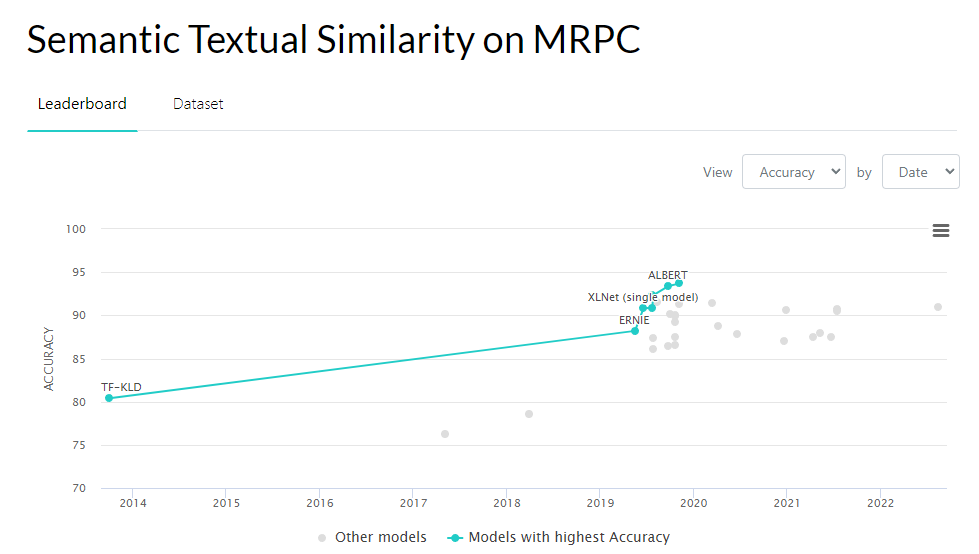

## Model 1: Use top model from multilingual textual similarity leaderboard

Best models:
- ALBERT (from google research) (93.4%) (A Lite BERT for Self-supervised Learning of Language Representations) (Focusing on reducing memory consumption)
- RoBERTa (from facebook research) (A Robustly Optimized BERT Pretraining Approach)

Meta provide a bigger ecosystem that support development so I choose RoBERTa.

In [2]:
from transformers import RobertaModel, RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

c:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
# This function tokenize sentences into tokens (most probably word pieces)

# padding ensures all sequences have the same length
# truncate = true will crop the sequence if it's longer than the maximum length that tokenizer can handle.

def encode_sentences(tokenizer, sentence_en, sentence_cn):
    tokens_en = tokenizer(sentence_en, return_tensors='pt', padding=True, truncation=True)
    tokens_cn = tokenizer(sentence_cn, return_tensors='pt', padding=True, truncation=True)
    return tokens_en, tokens_cn

In [4]:
def get_embeddings(model, tokens):
    with torch.no_grad():
        outputs = model(**tokens)
        embeddings = outputs.last_hidden_state[:, 0, :]
    return embeddings

In [5]:
from torch.nn.functional import cosine_similarity

def calculate_similarity(embedding1, embedding2):
    return cosine_similarity(embedding1, embedding2)

In [6]:
# Function to decode tokens and print them in key-value pairs
def print_decoded_tokens(token_ids, tokenizer):
    tokens = tokenizer.convert_ids_to_tokens(token_ids)
    for token_id, token in zip(token_ids, tokens):
        print(f"{token_id} match {token}")

In [7]:
import torch
for sentence_en, sentence_cn in sentence_pair:
    tokens_en, tokens_cn = encode_sentences(tokenizer, sentence_en, sentence_cn)
    embedding_en = get_embeddings(model, tokens_en)
    embedding_cn = get_embeddings(model, tokens_cn)
    similarity = calculate_similarity(embedding_en, embedding_cn)
    tuplee = (similarity.item(),sentence_en,sentence_cn)
    print(tuplee)

(0.9858294129371643, 'How a concept is framed, the context and associations with which it is presented, affect human judgments enormously. A tax called a “death tax” is regarded very differently from a tax called an “inheritance tax,” even though the two are really identical.', '只有货币错觉才能解释这一失败，而货币错觉最终又与心理学家所称的“构筑框架”相关。 人们如何构筑概念以及表述概念的背景和联系深刻地影响人们的判断。 尽管“死亡税”与“遗产税”其实是一码事，但是人们对这两种税收的看法相距甚远。 由于我们习惯于用货币的标准来框定经济价值，因此产生了货币错觉。')
(0.9972161054611206, 'The Global Economy’s Tale Risks', '全球经济的故事风险')
(0.9865499138832092, 'But experience and intuition can be supplemented by analytics, which is the purpose of my book. As Mark Twain once observed, a cat that sits on a hot stove will not sit on a hot stove again, but it won’t sit on a cold one, either.', '对领导能力的学习有许多种途径，从经验中学习是其中最常见、也是最有力的方式，它带给人们在危机中至关重要的习惯知识。 但分析学能为经验与直觉提供补充，而这正是我此书的宗旨。 正如马克·吐温曾经评论的那样，尝过烫火炉滋味的猫再也不会坐在烫火炉上，但它也不会坐在冷炉子上。')
(0.9872087836265564, 'With general-meeting season for publicly traded companies just beginning, now is the ideal t

The similarity score is suprisingly high.

- 1. Model arhitecture
Transformer-based models like RoBERTa generate contextual embeddings. Special tokens `<s>` and `</s>` that denote the start and end of a sentence highly influence the sentence embedding?

- 2. Default behavior:
RoBERT could be defaulting to a kind of "average" embedding for token it don't understand. 

In [8]:
import torch

# Example sentence pair (you should replace these with your actual sentences)
sentence_en = "This is a sentence in English."
sentence_cn = "这是一个中文句子。"

# Encoding sentences
tokens_en, tokens_cn = encode_sentences(tokenizer, sentence_en, sentence_cn)

print(f"Encoded English: {tokens_en}")
print("Decoded English tokens:")
print_decoded_tokens(tokens_en['input_ids'].squeeze().tolist(), tokenizer)
decoded_tokens_en = tokenizer.decode(tokens_en['input_ids'][0], skip_special_tokens=True)
print(f"Decoded English: {decoded_tokens_en}")

print(f"Encoded Chinese: {tokens_cn}")
print("\nDecoded Chinese tokens:")
print_decoded_tokens(tokens_cn['input_ids'].squeeze().tolist(), tokenizer)
decoded_tokens_cn = tokenizer.decode(tokens_cn['input_ids'][0], skip_special_tokens=True)
print(f"Decoded Chinese: {decoded_tokens_cn}")


# Getting embeddings
embedding_en = get_embeddings(model, tokens_en)
embedding_cn = get_embeddings(model, tokens_cn)

# Calculating similarity
similarity = calculate_similarity(embedding_en, embedding_cn)
print(f"\nSimilarity: {similarity.item()}")

Encoded English: {'input_ids': tensor([[   0,  713,   16,   10, 3645,   11, 2370,    4,    2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}
Decoded English tokens:
0 match <s>
713 match This
16 match Ġis
10 match Ġa
3645 match Ġsentence
11 match Ġin
2370 match ĠEnglish
4 match .
2 match </s>
Decoded English: This is a sentence in English.
Encoded Chinese: {'input_ids': tensor([[    0, 48145,    27, 48569, 48105, 46015, 10278, 47643, 47240,  6382,
         45262,  8210, 49156, 45682,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

Decoded Chinese tokens:
0 match <s>
48145 match è¿
27 match Ļ
48569 match æĺ¯
48105 match ä¸Ģ
46015 match ä¸
10278 match ª
47643 match ä¸Ń
47240 match æĸ
6382 match ĩ
45262 match åı
8210 match ¥
49156 match åŃĲ
45682 match ãĢĤ
2 match </s>
Decoded Chinese: 这是一个中文句子。

Similarity: 0.9928523302078247


## Interpreting the intermediate results:

`input_ids` output a dictionary containing the input IDs for the tokens. 
`attention_mask` allow the model to distinguish between the content and padding tokens during processing.

## How about putting 2 not related sentences?

In [9]:
import torch

# Example sentence pair (you should replace these with your actual sentences)
sentence_en = "This is a sentence in English."
sentence_cn = "英美民粹主义分道扬镳。"

# Encoding sentences
tokens_en, tokens_cn = encode_sentences(tokenizer, sentence_en, sentence_cn)

print(f"Encoded English: {tokens_en}")
print("Decoded English tokens:")
print_decoded_tokens(tokens_en['input_ids'].squeeze().tolist(), tokenizer)
decoded_tokens_en = tokenizer.decode(tokens_en['input_ids'][0], skip_special_tokens=True)
print(f"Decoded English: {decoded_tokens_en}")

print(f"Encoded Chinese: {tokens_cn}")
print("\nDecoded Chinese tokens:")
print_decoded_tokens(tokens_cn['input_ids'].squeeze().tolist(), tokenizer)
decoded_tokens_cn = tokenizer.decode(tokens_cn['input_ids'][0], skip_special_tokens=True)
print(f"Decoded Chinese: {decoded_tokens_cn}")


# Getting embeddings
embedding_en = get_embeddings(model, tokens_en)
embedding_cn = get_embeddings(model, tokens_cn)

# Calculating similarity
similarity = calculate_similarity(embedding_en, embedding_cn)
print(f"\nSimilarity: {similarity.item()}")

Encoded English: {'input_ids': tensor([[   0,  713,   16,   10, 3645,   11, 2370,    4,    2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}
Decoded English tokens:
0 match <s>
713 match This
16 match Ġis
10 match Ġa
3645 match Ġsentence
11 match Ġin
2370 match ĠEnglish
4 match .
2 match </s>
Decoded English: This is a sentence in English.
Encoded Chinese: {'input_ids': tensor([[    0, 36484, 13859, 15389, 36714,  4726, 12736, 48570,  3602, 36714,
         14292,  9253, 46015,  2023, 48732, 23171, 47166, 27819, 48583,  9085,
         48548, 11582, 41907, 15722, 15264, 45682,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]])}

Decoded Chinese tokens:
0 match <s>
36484 match è
13859 match ĭ
15389 match ±
36714 match ç
4726 match ¾
12736 match İ
48570 match æ°
3602 match ĳ
36714 match ç
14292 match ²
9253 match ¹
46015 match ä¸
2023 match »
48732 match ä¹
23171 match ī
47166 match åĪ
27819 match Ĩ


## How about comparing single language?

In [15]:
from transformers import RobertaModel, RobertaTokenizer
import torch
from torch.nn.functional import cosine_similarity

# Initialize tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

# Example sentence pairs
sentence1 = "This is a sentence in English."
sentence2 = "The Global Economy’s Tale Risks."

# Function to encode a single sentence and mask stop words and special tokens
def encode_sentence(tokenizer, sentence, stop_words=None):
    if stop_words is None:
        stop_words = []

    encoded_dict = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    input_ids = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask']

    # Create a mask for stop words and special tokens
    stop_word_mask = torch.ones(input_ids.size(), dtype=torch.bool)
    for idx, token_id in enumerate(input_ids.squeeze().tolist()):
        word = tokenizer.decode([token_id])
        if word in stop_words or word in tokenizer.all_special_tokens:
            stop_word_mask[0, idx] = False

    return encoded_dict, attention_mask, stop_word_mask

# Function to get embeddings from the model, excluding stop words and special tokens
def get_embeddings(model, encoded_sentence, stop_word_mask):
    with torch.no_grad():
        # Only pass the encoded_sentence dictionary, which already includes the attention mask
        outputs = model(**encoded_sentence)
        hidden_states = outputs.last_hidden_state

        # Apply the stop_word_mask to zero-out stop words and special tokens
        masked_hidden_states = hidden_states * stop_word_mask.unsqueeze(-1)
        # Calculate the sum and the number of non-masked tokens for average
        sum_embeddings = torch.sum(masked_hidden_states, dim=1)
        non_masked_tokens = stop_word_mask.sum(dim=1, keepdim=True)
        # Avoid division by zero for empty sentences by using max function
        average_embeddings = sum_embeddings / torch.max(non_masked_tokens, torch.tensor(1))

    return average_embeddings

# List of stop words (you might want to use a more comprehensive list)
stop_words = ["the", "a", "an", "in", "is", "are", "of", "and", "to", "this"]

# Encode sentences and mask stop words
tokens_sentence1, attention_mask1, stop_word_mask1 = encode_sentence(tokenizer, sentence1, stop_words)
tokens_sentence2, attention_mask2, stop_word_mask2 = encode_sentence(tokenizer, sentence2, stop_words)

# Get embeddings
embedding_sentence1 = get_embeddings(model, tokens_sentence1, stop_word_mask1)
embedding_sentence2 = get_embeddings(model, tokens_sentence2, stop_word_mask2)

# Calculate similarity (cosine similarity)
similarity = cosine_similarity(embedding_sentence1, embedding_sentence2)

print(f"Similarity: {similarity.item()}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Similarity: 0.9352315664291382
